In [1]:
import numpy as np
import cv2
from IPython.display import Image
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf


def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### ALPHBET+NUM SET GENERATE

In [2]:
import string

ALP = []
for i in range(10):
    ALP.append((i)%10)
for a in string.ascii_uppercase[:27]:
    ALP.append(a)
print (ALP)         
#ALP #-1 , (0-9) + (A-Z)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [3]:
def ImgtoFloat(route):
    
    raw=cv2.imread(route)
    gray = cv2.cvtColor(raw,cv2.COLOR_BGR2GRAY)
    gray = np.expand_dims(gray, axis=2)
    
    return gray


In [4]:
import os
import re

pwd = "./Data/English/Fnt/"
#Data = pd.DataFrame()
#Data = pd.DataFrame(columns = ("Input","Label"))
X_ALL=[]
y_ALL=[]

for path, dirs, files in os.walk(pwd):
    for dr in dirs:
        if (int(re.findall('\d+',dr)[0]) < 37):
            subpwd = os.path.join(path, dr)
            #print (subpwd)
            for sub_path, sub_dirs, sub_files in os.walk(subpwd):
                for subfile in sub_files:
                    sample = os.path.join(subpwd,subfile)
                    #Data.loc[len(Data)] = [ImgtoFloat(sample),int(re.findall('\d+',dr)[0])]
                    X_ALL.append(ImgtoFloat(sample))
                    y_ALL.append(int(re.findall('\d+',dr)[0])-1)
                print (subpwd,"Done.")

./Data/English/Fnt/Sample033 Done.
./Data/English/Fnt/Sample034 Done.
./Data/English/Fnt/Sample002 Done.
./Data/English/Fnt/Sample005 Done.
./Data/English/Fnt/Sample004 Done.
./Data/English/Fnt/Sample003 Done.
./Data/English/Fnt/Sample035 Done.
./Data/English/Fnt/Sample032 Done.
./Data/English/Fnt/Sample010 Done.
./Data/English/Fnt/Sample028 Done.
./Data/English/Fnt/Sample017 Done.
./Data/English/Fnt/Sample021 Done.
./Data/English/Fnt/Sample019 Done.
./Data/English/Fnt/Sample026 Done.
./Data/English/Fnt/Sample018 Done.
./Data/English/Fnt/Sample027 Done.
./Data/English/Fnt/Sample020 Done.
./Data/English/Fnt/Sample029 Done.
./Data/English/Fnt/Sample016 Done.
./Data/English/Fnt/Sample011 Done.
./Data/English/Fnt/Sample008 Done.
./Data/English/Fnt/Sample030 Done.
./Data/English/Fnt/Sample006 Done.
./Data/English/Fnt/Sample001 Done.
./Data/English/Fnt/Sample007 Done.
./Data/English/Fnt/Sample031 Done.
./Data/English/Fnt/Sample036 Done.
./Data/English/Fnt/Sample009 Done.
./Data/English/Fnt/S

In [5]:
from sklearn import cross_validation
X_ALL = np.array(X_ALL)
y_ALL = np.array(y_ALL)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_ALL,y_ALL,test_size=0.2)

#X_train.shape

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
height = 128
width = 128
channels = 1
n_inputs = height * width

conv1_fmaps = 8
conv1_ksize = 5
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 4
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 36

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 32 * 32])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss, global_step=global_step)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [7]:
from random import sample

def prepare_batch(X_train, y_train, batch_size):
    Batch = np.random.randint(0,len(X_train),batch_size)
    X_batch = np.stack(X_train[idx] for idx in Batch)
    y_batch = np.stack(y_train[idx] for idx in Batch)
    
    return X_batch, y_batch

#X_batch, y_batch = prepare_batch(Data,10)
#print (len(list(Data["Label"])))
#X_batch, y_batch = prepare_batch(Data,100)
#print (X_batch.shape, y_batch.shape)


In [8]:
n_epochs = 10
batch_size = 100
checkpoint_path = "./Saved/LetterCNN.ckpt"

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train) // batch_size):
            X_batch, y_batch = prepare_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test}) 
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, checkpoint_path)

0 Train accuracy: 0.13 Test accuracy: 0.109486
1 Train accuracy: 0.31 Test accuracy: 0.227857
2 Train accuracy: 0.47 Test accuracy: 0.488928
3 Train accuracy: 0.55 Test accuracy: 0.626299
4 Train accuracy: 0.73 Test accuracy: 0.747676
5 Train accuracy: 0.76 Test accuracy: 0.785812
6 Train accuracy: 0.88 Test accuracy: 0.803034
7 Train accuracy: 0.87 Test accuracy: 0.822717
8 Train accuracy: 0.9 Test accuracy: 0.83871
9 Train accuracy: 0.94 Test accuracy: 0.849781


In [ ]:
n_epochs = 10
batch_size = 100
checkpoint_path = "./Saved/LetterCNN.ckpt"

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    for epoch in range(n_epochs):
        for iteration in range(len(X_train) // batch_size):
            X_batch, y_batch = prepare_batch(X_train, y_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test}) 
        print(epoch,"Train accuracy:", acc_train, "Test accuracy:", acc_test)

        save_path = saver.save(sess, checkpoint_path)

## Restore and Run

(231, 37)
[[ 0.99998329  0.00578025 -0.21001022]
 [-0.00578025  0.99998329  1.33585592]]


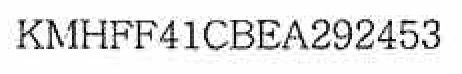

In [10]:
Raw = cv2.imread("./Image/Core/Core.png")
img = Raw.copy()

### Rotate .. 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.bitwise_not(gray)
thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
coords = np.column_stack(np.where(thresh > 0))
angle = cv2.minAreaRect(coords)[-1]
#coords.shape
rect=cv2.minAreaRect(coords)
#print(rect)
points = cv2.boxPoints(rect)
#print(points)
points = np.int0(np.around(points))

if angle < -45:
	angle = -(90 + angle)

else:
	angle = -angle

(h, w) = img.shape[:2]
center = (w // 2, h // 2)

print(center)

M = cv2.getRotationMatrix2D(center, angle, 1.0)

print(M)
rotated = cv2.warpAffine(img, M, (w, h),
	flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

cv2.imwrite('./rotated.jpg',rotated)
Image('./rotated.jpg')



[[31, 75], [79, 133], [141, 185], [189, 230], [234, 271], [276, 306], [318, 341], [352, 393], [399, 439], [445, 483], [487, 531], [538, 570], [576, 608], [615, 646], [653, 684], [691, 722], [729, 760]]


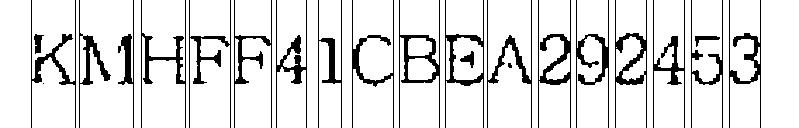

In [11]:

### END of Rotate Part 

gray = cv2.cvtColor(rotated,cv2.COLOR_BGR2GRAY)
    
height,width = gray.shape
ratio_w = int(128/height * width)

Re_gray = cv2.resize(gray,(ratio_w,128),interpolation=cv2.INTER_LINEAR)
re_height, re_width = Re_gray.shape

ret,thresh = cv2.threshold(Re_gray,127,255,0)
For_Check = thresh.copy()

white_space = re_height*255

End_Point = []
Start_Point = []

for i in range(re_width-1):
    if (np.sum(thresh[:re_height, i])==white_space)&(np.sum(thresh[:re_height, i+1])!=white_space):
        Start_Point.append(i)
        #cv2.line(For_Check, (i, 0), (i, re_height), (0, 0, 255), 1)
    if (np.sum(thresh[:re_height, i])!=white_space)&(np.sum(thresh[:re_height, i+1])==white_space):
        End_Point.append(i)
        #cv2.line(For_Check, (i, 0), (i, re_height), (0, 0, 255), 1)

#Start_point = [i for i in End_Point[:-1]]

if (np.sum(thresh[:re_height,0])!=white_space):
    Start_Point.insert(0,0)
if (np.sum(thresh[:re_height,-1])!=white_space):
    End_Point.append(re_width)    

Location = list([a,b] for a,b in zip(Start_Point, End_Point))

#print(Start_Point)
#print(End_Point)
#print(Location)
#print(len(location))

while(len(Location) > 17):
    
    Loc_len = []
    for i in range(len(Location)):
        Loc_len.append(Location[i][1]-Location[i][0])

    #print (np.argmin(Loc_len))
    min_idx = np.argmin(Loc_len)
    len_merge_left, len_merge_right = -1, -1
    if (min_idx != 0):
        len_merge_left = Loc_len[min_idx] + Loc_len[min_idx-1]
    else:
        len_merge_left = 999999

    if (min_idx != len(Loc_len)):
        len_merge_right = Loc_len[min_idx] + Loc_len[min_idx+1]
    else:
        len_merge_right = 999999

    if (len_merge_left < len_merge_right):
        Location[min_idx-1][1]= Location[min_idx][1]
    else:
        Location[min_idx+1][0]= Location[min_idx][0]
    del Location[min_idx]
    
for i in range(len(Location)):
    cv2.line(For_Check, (Location[i][0], 0), (Location[i][0], re_height), (0, 0, 255), 1)
    cv2.line(For_Check, (Location[i][1], 0), (Location[i][1], re_height), (0, 0, 255), 1)
        
print(Location)

cv2.imwrite('./test.jpg',For_Check)
Image('./test.jpg')

In [12]:
SAMPLE = []
    
for order in range(len(Location)):
    start = Location[order][0]
    end = Location[order][1]

    front_len = int((128 - (end-start))/2)
    end_len = int((128 - (end-start))/2)
    #print (front_len,end_len,end-start,front_len+end_len+end-start)

    if (front_len + end_len + end-start != 128):
        front_len = front_len+1
        # or end_len = end_len+1

    center_rec = thresh[0:128,start:end]
    left_rec = np.zeros((128,front_len),np.uint8)
    left_rec[:,:] = (255)
    right_rec = np.zeros((128,end_len),np.uint8)
    right_rec[:,:] = (255)
    left_center = np.hstack((left_rec,center_rec))
    full = np.hstack((left_center,right_rec))
    #full = cv2.hconcat(left_center,right_rec)

    #print(full.shape)
    Input = np.expand_dims(full, axis=2)
    SAMPLE.append(Input)

SAMPLE = np.array(SAMPLE)


(17, 128, 128, 1)


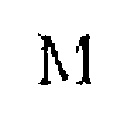

In [13]:
print (SAMPLE.shape)

cv2.imwrite('./sample.jpg',SAMPLE[1])
Image('./sample.jpg')

In [15]:
checkpoint_path = "./saved/LetterCNN.ckpt"
#n_outputs = 10

with tf.Session() as sess:
    
    #init.run()
    saver.restore(sess, checkpoint_path)
    #sess.run(training_op, feed_dict={X: X_Sample, y: y_Sample})
    #sess.run(Y_proba, feed_dict = {X: Input})
    
    string_set = ""
    
    for idx in range(len(SAMPLE)):
        BATCH = []
        #Input = np.expand_dims(SAMPLE[idx], axis=2)
        BATCH.append(SAMPLE[idx])
        
        #Input = np.expand_dims(SAMPLE[idx], axis=2)
        #print(Input.shape)
        
        real_test = Y_proba.eval(feed_dict={X: BATCH})
        idx = np.argmax(real_test)

        #print (idx, ALP[idx], np.max(real_test), "\n", real_test)
        string_set = string_set+str(ALP[idx])
    print (string_set)

INFO:tensorflow:Restoring parameters from ./saved/LetterCNN.ckpt
4MY1L11151571715A


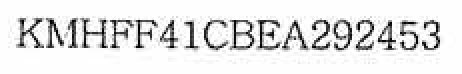

In [16]:
Image('./Image/Core/Core.png')